In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


%matplotlib inline

In [23]:
c = 299792458 # m/s
e = 1.602176634e-19 # C 
muon_mass = 105.6583755e6*e / (c**2) # kg
electron_mass = 0.51099895000*e/(c**2) # kg

## Loading data

In [24]:
raw_data = pd.read_csv("./data/dataset.txt",sep=" ",index_col=False)
raw_data=raw_data[raw_data["pz_positron"]>0].reset_index(drop=True)
number_events = raw_data["x_scattering"].shape[0]
raw_data

,x_scattering,y_scattering,z_scattering,px_mu1,py_mu1,pz_mu1,px_mu2,py_mu2,pz_mu2,px_positron,py_positron,pz_positron
0,0.006700,-0.000174,0.013579,0.026168,0.005782,27.3669,-0.026168,-0.005782,20.2281,0,0,47.5950
1,-0.001808,0.005898,0.000123,0.029397,-0.004837,19.3068,-0.029397,0.004837,30.3273,0,0,49.6341
2,0.001924,-0.004531,0.010167,0.001136,-0.023830,28.3075,-0.001136,0.023830,19.3267,0,0,47.6342
3,0.007570,0.004268,0.008222,-0.002160,-0.011196,17.4952,0.002160,0.011196,30.0357,0,0,47.5309
4,0.004862,-0.005216,0.011934,0.031203,0.005236,21.6927,-0.031203,-0.005236,26.3991,0,0,48.0918
...,...,...,...,...,...,...,...,...,...,...,...,...
999909,-0.002064,-0.006667,0.024110,0.013418,0.010555,26.1718,-0.013418,-0.010555,19.6198,0,0,45.7916
999910,-0.001824,-0.001494,0.026105,0.003372,0.019434,25.1396,-0.003372,-0.019434,20.5562,0,0,45.6958
999911,0.002128,-0.000650,0.028801,0.009716,0.008148,21.7877,-0.009716,-0.008148,22.5688,0,0,44.3564
999912,-0.000129,-0.003546,0.014003,-0.017934,0.020388,19.8603,0.017934,-0.020388,28.1794,0,0,48.0397


In [25]:
# here we rename all the columns to use an easy notation x y z
R_scattering = raw_data[['x_scattering', 'y_scattering', 'z_scattering']].rename(columns={'x_scattering': 'x', 'y_scattering': 'y', 'z_scattering': 'z'})
P_e = raw_data[['px_positron', 'py_positron', 'pz_positron']].rename(columns={'px_positron': 'x', 'py_positron': 'y', 'pz_positron': 'z'})
P_mu = raw_data[['px_mu1', 'py_mu1', 'pz_mu1']].rename(columns={'px_mu1': 'x', 'py_mu1': 'y', 'pz_mu1': 'z'})
P_anti_mu = raw_data[['px_mu2', 'py_mu2', 'pz_mu2']].rename(columns={'px_mu2': 'x', 'py_mu2': 'y', 'pz_mu2': 'z'})

# Detectors for positrons and muons

### Helper functions for this section

In [26]:
def get_velocity(p,m):
    vx = p["x"]*1e9*e/(c*m)
    vy = p["y"]*1e9*e/(c*m)
    vz = p["z"]*1e9*e/(c*m)
    v=pd.DataFrame({"x":vx,"y":vy,"z":vz})

    return v

In [27]:
def propagate_particles(r_old, p, z_new, m):
    # find proper time
    v=get_velocity(p,m)
    t=(z_new-r_old["z"])/v["z"]

    # compute new positions
    x_new = r_old["x"] + v["x"]*t
    y_new = r_old["y"] + v["y"]*t
    z_new = r_old["z"] + v["z"]*t
    
    r_new = pd.DataFrame({"x":x_new,"y":y_new,"z":z_new})
    return r_new

In [28]:
def get_edges(pixel_length, x_center, y_center, x_length, y_length, oversize_pixels = 20):

    edges_x = np.arange(x_center-x_length/2 -oversize_pixels * pixel_length, x_center + x_length/2 + oversize_pixels * pixel_length ,pixel_length)
    edges_y = np.arange(y_center-y_length/2 -oversize_pixels * pixel_length, y_center + y_length/2 + oversize_pixels * pixel_length ,pixel_length)

    return [edges_x, edges_y]

In [29]:
class Detector:
    
    def __init__(self, x_center, y_center, z_center, x_length, y_length, pixel_length):
        self.x_center = x_center
        self.y_center = y_center
        self.z_center = z_center
        self.x_length = x_length
        self.y_length = y_length
        self.pixel_length = pixel_length
        self.dataset_dict = {}

        # create an array with all pixel_centers
        self.npixels_x = int(x_length / pixel_length)
        self.npixels_y = int(y_length / pixel_length)
        x_range = np.linspace(x_center - x_length/2 + pixel_length/2, x_center + x_length/2 - pixel_length/2, self.npixels_x)
        y_range = np.linspace(y_center - y_length/2 + pixel_length/2, y_center + y_length/2 - pixel_length/2, self.npixels_y)
        x, y = np.meshgrid(x_range, y_range)
        self.pixel_centers = np.column_stack((x.flatten(), y.flatten(), self.z_center*np.ones(len(x_range)*len(y_range) )))

        # control values
        self.is_noise_generated = False
        self.n_events = 0

    def load_data(self,R_positions: pd.DataFrame, label = "none"):
        #check if the label is already there

        if label in self.dataset_dict.keys():
            print("ERROR: trying to add a dataset with a label already in used --> stop")
            exit()

        if self.n_events == 0:
            self.n_events = R_positions.shape[0]
        else:
            if R_positions.shape[0]!=self.n_events:
                print("ERROR: trying to add a datased with a different number of events with respect to the previous one --> stop")
        
        hits_map = R_positions.copy()
        # center on 0,0 so we can get properly the pixel with respect to the detector center
        hits_map["x"] = hits_map["x"] - self.x_center 
        hits_map["y"] = hits_map["y"] - self.y_center

        # find the pixel center
        hits_map["x"] = np.trunc(hits_map["x"] / pixel_length ) * pixel_length + np.sign(hits_map["x"]) * pixel_length / 2
        hits_map["y"] = np.trunc(hits_map["y"] / pixel_length ) * pixel_length + np.sign(hits_map["y"]) * pixel_length / 2

        # put everything back in the correct place 
        hits_map["x"] = hits_map["x"] + self.x_center
        hits_map["y"] = hits_map["y"] + self.y_center        
        self.dataset_dict[label]=hits_map
        
    def get_positions(self,label = "none"):

        if label not in self.dataset_dict.keys():
            print("ERROR: trying to get the positions of a dataset with label {}, but it is not there --> stop".format(label))
        
        return self.dataset_dict[label]

    def generate_poisson_noise(self,lambda_param):
        if self.n_events == 0:
            print("ERROR: trying to create noise but no dataset loaded -->stop")
            exit()
        self.is_noise_generated = True
        
        n_noise_per_trigger = np.random.poisson(lambda_param, size=self.n_events)    
        random_indices = np.random.choice(self.pixel_centers.shape[0], size=np.sum(n_noise_per_trigger))
        
        self.noise_list = np.split(self.pixel_centers[random_indices], np.cumsum(n_noise_per_trigger)[:-1])

    def get_noise_events(self, trigger_number):
        if not self.is_noise_generated:
            print("ERROR: trying to get a noise event, but noise is not generated yet! --> stop")
            exit()
        list_events = self.noise_list[trigger_number]
        if len(list_events) != 0:
            list_events = np.vstack(list_events)
            return np.unique(list_events, axis=0)
        return np.array(list_events)
    
    def get_real_events(self, trigger_number):
        # if there the same pixel more than one time remove the duplicates
        list_events = [data.loc[trigger_number].values for data in self.dataset_dict.values()]
        list_events = np.vstack(list_events)
        unique_pixels = np.unique(list_events, axis=0)
        return unique_pixels

    def get_trigger(self, trigger_number):
        real_list = self.get_real_events(trigger_number)
        noise_list = self.get_noise_events(trigger_number)
        all_events = np.vstack([real_list,noise_list])
        unique_events = np.unique(all_events, axis=0)
        return unique_events
            
        

In [30]:
def choose_detector_specs(r, tolerance, pixel_length, verbose = True):
    # find max and min and center
    x_min, x_max = r["x"].min()*tolerance, r["x"].max()*tolerance
    y_min, y_max = r["y"].min()*tolerance, r["y"].max()*tolerance
    x_center = round((x_max + x_min )/2, 4)
    y_center = round((y_max + y_min )/2, 4)

    #find proper detector dimention taking into account the size of each single pixel
    half_x = (x_max-x_min)*tolerance / 2
    half_x = int(half_x / pixel_length) * pixel_length # now this value is a multiple of pixel_length
    length_detector_x = 2*half_x
    n_pixels_x = length_detector_x/pixel_length

    half_y = (y_max-y_min)*tolerance / 2
    half_y = int(half_y / pixel_length) * pixel_length
    length_detector_y = 2*half_y
    n_pixels_y = length_detector_y/pixel_length

    #brief summary
    if verbose:
        print("\nfor detector at z={} m we choose:\n".format(round(r["z"][0], 3)),
              "- length".format(r["z"][0]), "of {} m along x and {} m along y\n".format(round(length_detector_x,6), round(length_detector_y,6)),
              "- center in ({}, {}) m \n".format(x_center,y_center),
              "- with square pixels of size {}x{} μm the detector is a matrix of {}x{} pixels".format(pixel_length*1e6,pixel_length*1e6, round(n_pixels_x), round(n_pixels_y)))
        
    return x_center, y_center, r["z"][0], length_detector_x, length_detector_y, pixel_length
    return 

In [31]:
def place_detector_on_hitsmap(ax, x_center, y_center, length_detector_x, length_detector_y):
    x_min = x_center - length_detector_x/2
    y_min = y_center - length_detector_y/2
    square = Rectangle((x_min, y_min), length_detector_x, length_detector_y, linewidth=1.5, edgecolor='red', facecolor='none',label="detector")
    _ = ax.add_patch(square)
    ax.legend(loc='upper right')
 
    return

## Analysis for positrons

### Code

In [32]:
z_positron_detectors = np.array([-0.30, -0.15]) # z of the silicon trackers before berillium target (we're traking positrons here)

r_upstream_positions = {}
positron_detectors= {}
for z_new in z_positron_detectors:
    r_upstream_positions[z_new]=R_scattering.copy()
    r_upstream_positions[z_new]["z"]=np.ones(number_events)*z_new

Assuming square pixels of size 200.0x200.0 μm and a tolerance of 1.05 %

for detector at z=-0.3 m we choose:
 - length of 0.022 m along x and 0.022 m along y
 - center in (-0.0, 0.0) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 110x110 pixels

for detector at z=-0.15 m we choose:
 - length of 0.022 m along x and 0.022 m along y
 - center in (-0.0, 0.0) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 110x110 pixels


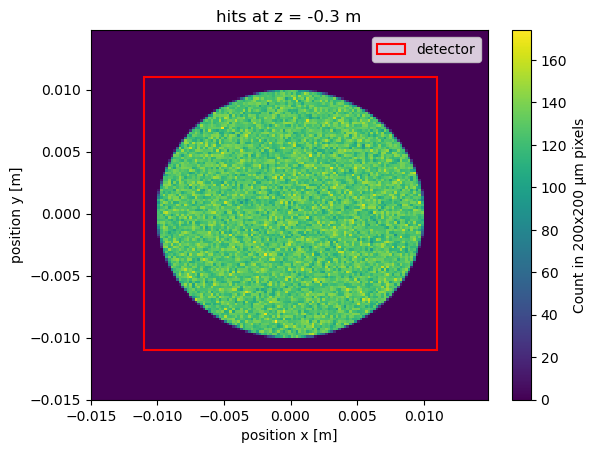

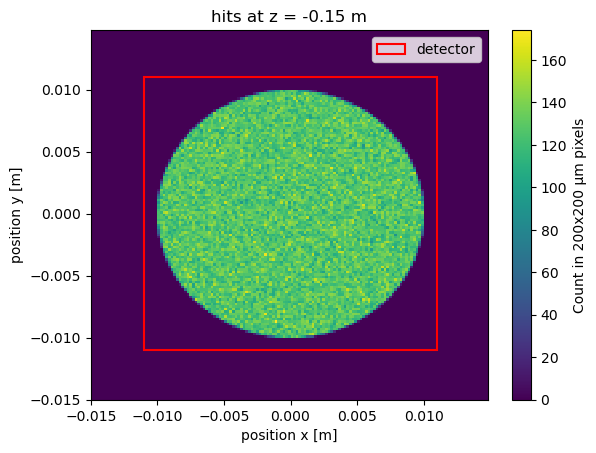

In [33]:
pixel_length = 200e-6 #m
tolerance = 1.05 #%
print("Assuming square pixels of size {}x{} μm and a tolerance of {} %".format(pixel_length*1e6,pixel_length*1e6, tolerance))
for z_pos, data in  r_upstream_positions.items():
    # create hits map 
    x_center, y_center, z_center, x_length, y_length, pixel_length = choose_detector_specs(data,tolerance,pixel_length)
    detector = Detector(x_center, y_center,z_center,x_length, y_length, pixel_length)
    detector.load_data(data)
    positron_detectors[z_pos]=detector

    #plot hits_map
    df_positions = detector.get_positions()
    fig, ax = plt.subplots(1,1)
    hist = ax.hist2d(df_positions["x"],df_positions["y"],bins=get_edges(pixel_length, x_center, y_center, x_length, y_length), cmap = "viridis")
    cbar = fig.colorbar(hist[3], ax=ax, cmap="viridis")
    pixel_length_label = round(pixel_length*1e6)
    cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
    ax.set_xlabel("position x [m]")
    ax.set_ylabel("position y [m]")
    ax.set_title("hits at z = {} m".format(data["z"][0]))
    place_detector_on_hitsmap(ax, x_center, y_center, x_length, y_length)

### Comments on positrons

## Analysis for muons before magnetic field

### Code

In [34]:
z_downstream_muons_detectors = np.array([5, 6, 7])

r_downstream__muons_positions = {}
upstream_muons_detectors = {}
for z_new in z_downstream_muons_detectors:
    R_mu_tmp = propagate_particles(R_scattering,P_mu,z_new,muon_mass)
    R_anti_mu_tmp = propagate_particles(R_scattering,P_anti_mu,z_new,muon_mass)
    data_tmp = {"n": R_mu_tmp.copy(), "p": R_anti_mu_tmp.copy()}
    r_downstream__muons_positions[z_new]=data_tmp

Assuming square pixels of size 50.0x50.0 μm and a tolerance of 1.05 %:

for detector at z=5.0 m we choose:
 - length of 0.0396 m along x and 0.0401 m along y
 - center in (0.0001, -0.0) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 792x802 pixels
 ATTENTION: in this case only 0.0013% of the pairs are at a distance smaller than the pixel size

for detector at z=6.0 m we choose:
 - length of 0.0432 m along x and 0.0438 m along y
 - center in (0.0001, -0.0) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 864x876 pixels
 ATTENTION: in this case only 0.0012% of the pairs are at a distance smaller than the pixel size

for detector at z=7.0 m we choose:
 - length of 0.0468 m along x and 0.0476 m along y
 - center in (0.0001, 0.0) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 936x952 pixels
 ATTENTION: in this case only 0.0009% of the pairs are at a distance smaller than the pixel size


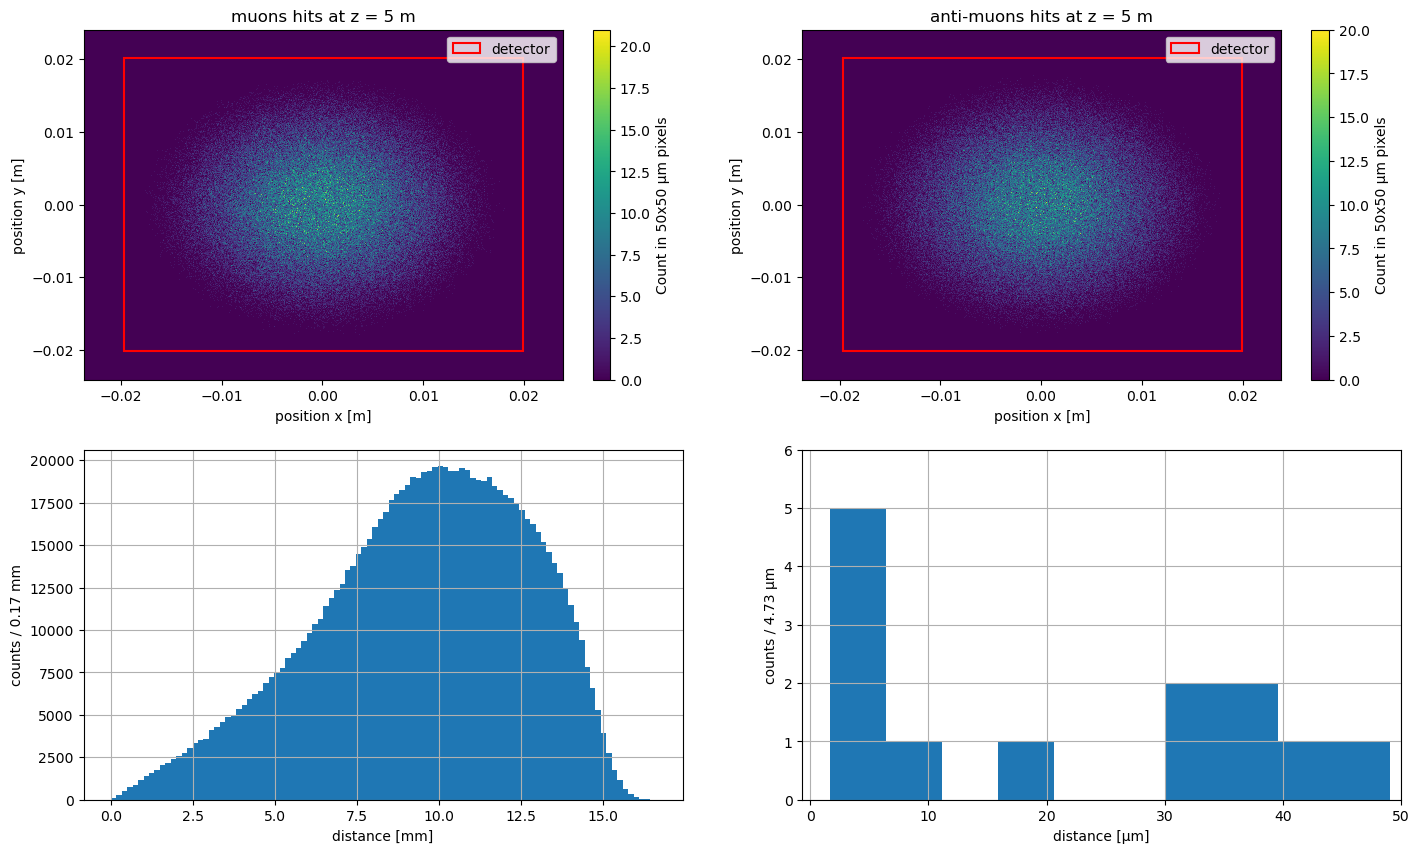

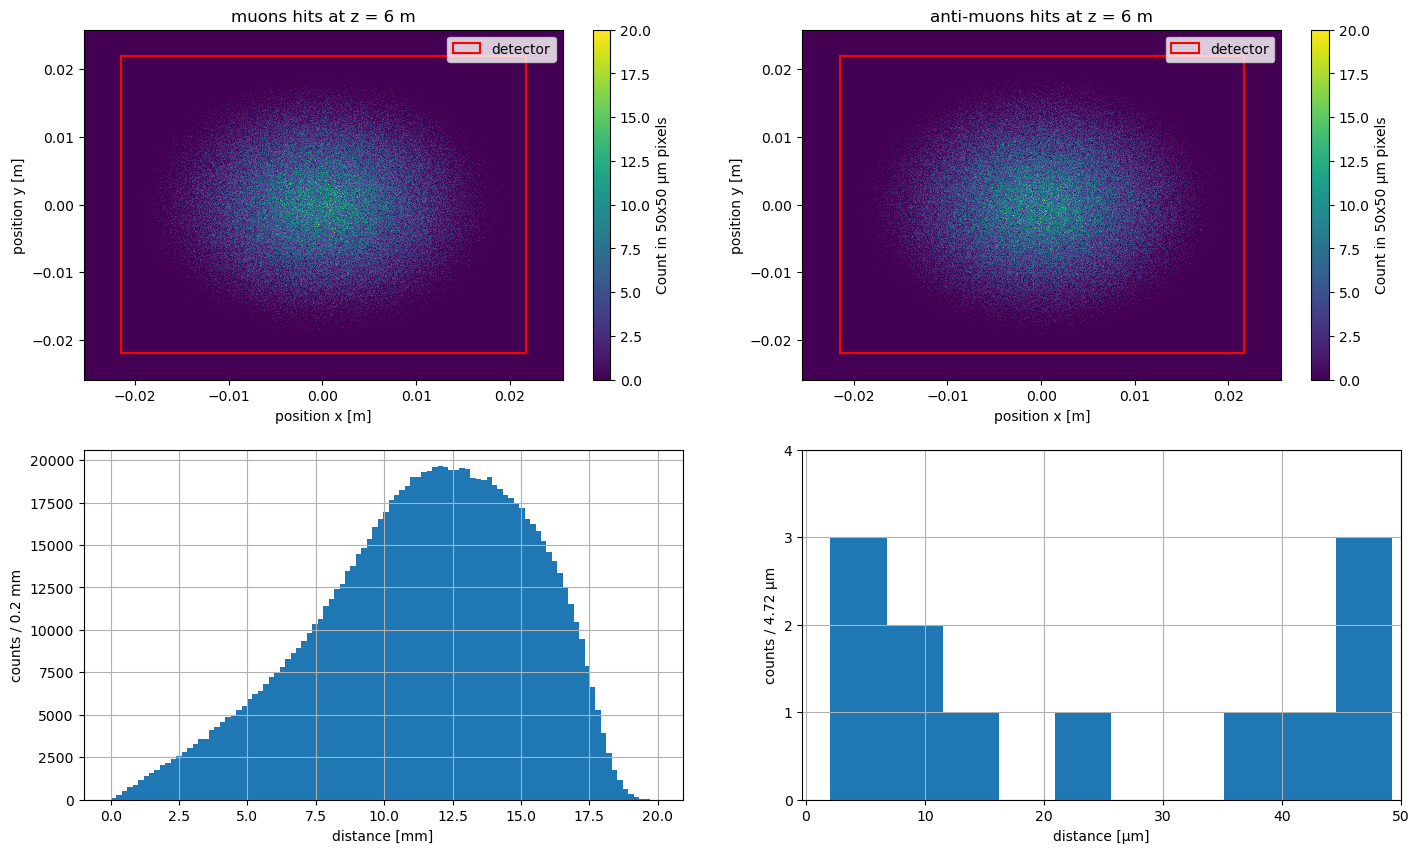

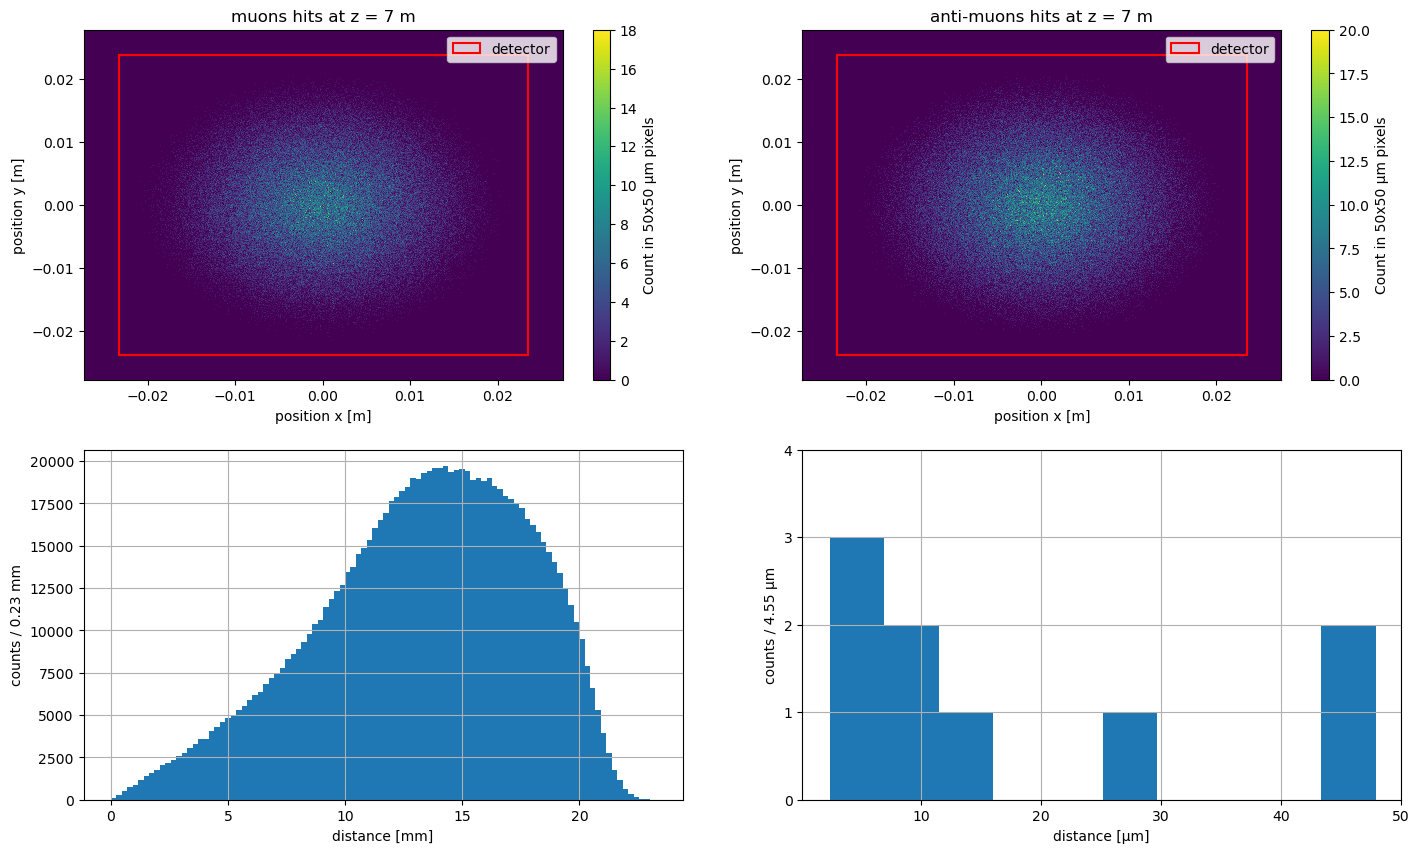

In [35]:
pixel_length = 50e-6 #m
tolerance = 1.05 #%
print("Assuming square pixels of size {}x{} μm and a tolerance of {} %:".format(pixel_length*1e6,pixel_length*1e6, tolerance))

for z_new, data_dic in  r_downstream__muons_positions.items():
    # create hits map
    total_dataset = pd.concat(data_dic.values(),ignore_index=True)
    x_center, y_center, z_center, x_length, y_length, pixel_length = choose_detector_specs(total_dataset,tolerance,pixel_length)
    edges = get_edges(pixel_length, x_center, y_center, x_length, y_length, 80)

    detector_tmp = Detector(x_center, y_center, z_center, x_length, y_length, pixel_length)
    detector_tmp.load_data(data_dic["p"],"p")
    detector_tmp.load_data(data_dic["n"],"n")

    upstream_muons_detectors[z_new]=detector_tmp

    #plot hits maps
    df_positions_p = detector_tmp.get_positions("p")
    df_positions_n = detector_tmp.get_positions("n")
    fig, ax = plt.subplots(2,2, figsize = (17,10) )
    hist_muons_p = ax[0,0].hist2d(df_positions_p["x"],df_positions_p["y"],bins=edges, cmap = "viridis")
    hist_muons_n = ax[0,1].hist2d(df_positions_n["x"],df_positions_n["y"],bins=edges, cmap = "viridis")
 
    histograms_2d = [hist_muons_n, hist_muons_p]
    labels = ["muons", "anti-muons"]

    for a, hist, label in zip(ax[0],histograms_2d, labels):
        cbar = fig.colorbar(hist[3], ax=a, cmap="viridis")
        pixel_length_label = round(pixel_length*1e6)
        cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
        a.set_xlabel("position x [m]")
        a.set_ylabel("position y [m]")
        a.set_title("{} hits at z = {} m".format(label, z_new))
        place_detector_on_hitsmap(a, x_center, y_center, x_length, y_length)

    
    #plot 1d histogram with separation between pairs distribution
    df_dist = (data_dic["p"]-data_dic["n"])
    abs_dist = np.sqrt(df_dist["x"]**2 + df_dist["y"]**2 ) # distance in m
    abs_dist_small = abs_dist[abs_dist < pixel_length]     # select events with distance between muons < pixel_length

    abs_dist=abs_dist*1e3                # conversion from m --> mm to make the graph easier to read
    abs_dist_small=abs_dist_small*1e6    # conversion from m --> μm to make the graph easier to read
    
    hist_dist = ax[1,0].hist(abs_dist,bins=100)
    hist_dist_lost = ax[1,1].hist(abs_dist_small,bins=10)
    ax[1,1].set_xlim(right = pixel_length*1e6)
    ax[1,1].set_yticks(range( int(hist_dist_lost[0].max())+2))

    ax[1,0].set_xlabel("distance [mm]")
    ax[1,1].set_xlabel("distance [μm]")
    
    ax[1,0].grid(True)
    ax[1,1].grid(True)

    ax[1,0].set_ylabel("counts / {} mm".format(round(hist_dist[1][1]-hist_dist[1][0],2)))
    ax[1,1].set_ylabel("counts / {} μm".format(round(hist_dist_lost[1][1]-hist_dist_lost[1][0],2)))

    fraction_pair_lost = round(np.sum(hist_dist_lost[0])*100/np.sum(hist_dist[0]),6)
    print(" ATTENTION: in this case only {}% of the pairs are at a distance smaller than the pixel size".format(fraction_pair_lost))    
    

In [36]:
df = upstream_muons_detectors[5]
df_m = df.get_positions("n")
df_am = df.get_positions("p")
print(df_am)
print(df_m)

               x         y    z
0       0.000225 -0.001575  5.0
1      -0.006675  0.006675  5.0
2       0.001625  0.001625  5.0
3       0.007925  0.006125  5.0
4      -0.001025 -0.006225  5.0
...          ...       ...  ...
999909 -0.005475 -0.009325  5.0
999910 -0.002625 -0.006175  5.0
999911 -0.000025 -0.002425  5.0
999912  0.003025 -0.007175  5.0
999913 -0.001575 -0.006825  5.0

[999914 rows x 3 columns]
               x         y    z
0       0.011475  0.000875  5.0
1       0.005825  0.004625  5.0
2       0.002125 -0.008725  5.0
3       0.006975  0.001075  5.0
4       0.012025 -0.004025  5.0
...          ...       ...  ...
999909  0.000475 -0.004675  5.0
999910 -0.001175  0.002375  5.0
999911  0.004325  0.001225  5.0
999912 -0.004625  0.001575  5.0
999913 -0.008675  0.003875  5.0

[999914 rows x 3 columns]


In [48]:
df.get_real_events(3)

array([[6.975e-03, 1.075e-03, 5.000e+00],
       [7.925e-03, 6.125e-03, 5.000e+00]])

In [38]:
df.generate_poisson_noise(1)

In [49]:
df.get_noise_events(3)

array([], shape=(0, 3), dtype=float64)

In [51]:
df.get_trigger(3)

array([[6.975e-03, 1.075e-03, 5.000e+00],
       [7.925e-03, 6.125e-03, 5.000e+00]])

## Propagation of the muons and antimuons in the magnetic field

### Helper functions for this subsection


In [52]:
def propagate_muons_in_Bfield(R_entrance, p_entrance, z_exit, m, B):
    p_perp = np.sqrt(p_entrance["x"]**2 + p_entrance["z"]**2) # S. I. units
    R = p_perp*1e9/(c*B)
    x_centre = R_entrance["x"] + R*p_entrance["z"]/p_perp
    z_centre = R_entrance["z"] - R*p_entrance["x"]/p_perp

    z_new = np.ones(len(R))*z_exit
    x_new = x_centre - np.sqrt(R**2 - (z_new-z_centre)**2)

    chord = np.sqrt( (z_new-R_entrance["z"])**2 + (x_new-R_entrance["x"])**2 )
    theta = np.sin(chord/(2*R))
    arc = theta*R
    y_new = R_entrance["y"] + arc*p_entrance["y"]/p_perp
    r_new = pd.DataFrame({"x": x_new, "y": y_new, "z": z_new})
    
    return r_new, theta


def propagate_antimuons_in_Bfield(R_entrance, p_entrance, z_exit, m, B):
    p_perp = np.sqrt(p_entrance["x"]**2 + p_entrance["z"]**2) # S. I. units
    R = p_perp*1e9/(c*B)
    x_centre = R_entrance["x"] - R*p_entrance["z"]/p_perp  # different sign here for antimuons
    z_centre = R_entrance["z"] + R*p_entrance["x"]/p_perp

    z_new = np.ones(len(R))*z_exit
    x_new = x_centre + np.sqrt(R**2 - (z_new-z_centre)**2)

    chord = np.sqrt( (z_new-R_entrance["z"])**2 + (x_new-R_entrance["x"])**2 )
    theta = np.arcsin(chord/(2*R))
    arc = theta*R
    y_new = R_entrance["y"] + arc*p_entrance["y"]/p_perp
    r_new = pd.DataFrame({"x": x_new, "y": y_new, "z": z_new})
    
    return r_new, theta


def propagate_mu_momenta(p_entrance, rot_angle):
    px_new = p_entrance["z"]*np.sin(rot_angle)+p_entrance["x"]*np.cos(rot_angle)
    py_new = p_entrance["y"]
    pz_new = p_entrance["z"]*np.cos(rot_angle)-p_entrance["x"]*np.sin(rot_angle)
    p_new = pd.DataFrame({"x": px_new, "y": py_new, "z": pz_new})
    
    return p_new


def propagate_antimu_momenta(p_entrance, rot_angle):
    px_new = -p_entrance["z"]*np.sin(rot_angle)+p_entrance["x"]*np.cos(rot_angle)
    py_new = p_entrance["y"]
    pz_new = p_entrance["z"]*np.cos(rot_angle)+p_entrance["x"]*np.sin(rot_angle)
    p_new = pd.DataFrame({"x": px_new, "y": py_new, "z": pz_new})
    
    return p_new

### Code

In [53]:
B = 1.7 # T
L = 2 # m
z_mag = 8 # m

In [54]:
R_mu_entrance = propagate_particles(R_scattering, P_mu, z_mag, muon_mass)
R_anti_mu_entrance = propagate_particles(R_scattering, P_anti_mu, z_mag, muon_mass)

#### Quick check

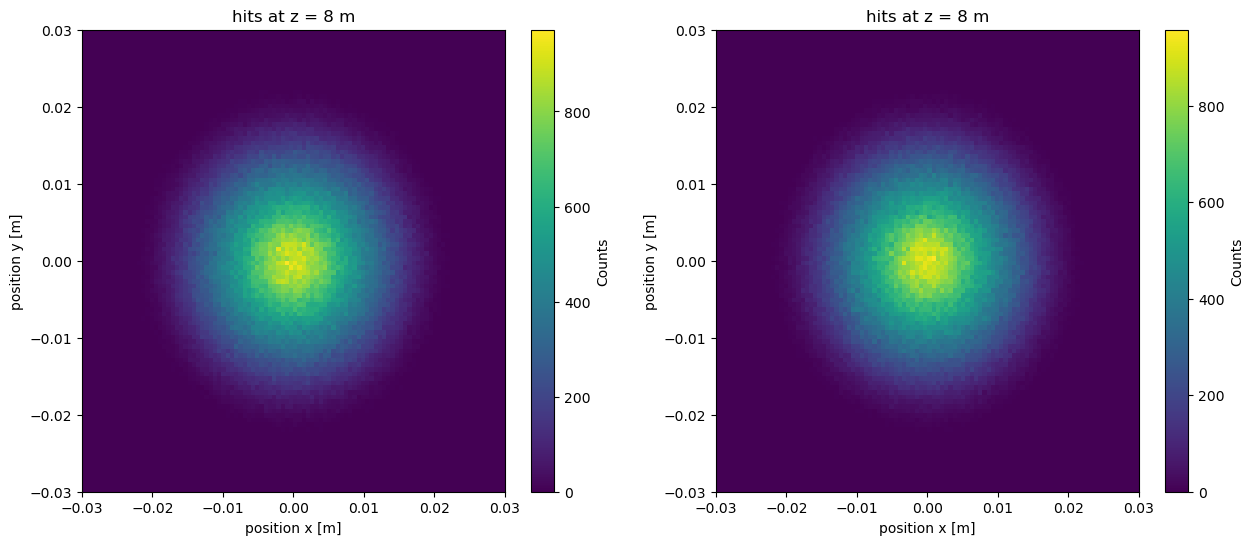

In [55]:
# this part is just to have a quick visual idea of the position of the μ at the beginning of the B field region
# it can be deleted later
fig, ax = plt.subplots(1, 2, figsize=(15,6))
hist0 = ax[0].hist2d(R_mu_entrance["x"], R_mu_entrance["y"], bins=(100,100), range=[[-0.03,0.03],[-0.03,0.03]], cmap = "viridis")
colorbar = fig.colorbar(hist0[3], ax=ax[0], cmap="viridis")
colorbar.set_label('Counts')
ax[0].set_xlabel("position x [m]")
ax[0].set_ylabel("position y [m]")
ax[0].set_title("hits at z = {} m".format(z_mag))

hist1 = ax[1].hist2d(R_anti_mu_entrance["x"], R_anti_mu_entrance["y"], bins=(100,100), range=[[-0.03,0.03],[-0.03,0.03]], cmap = "viridis")
colorbar = fig.colorbar(hist1[3], ax=ax[1], cmap="viridis")
colorbar.set_label('Counts')
ax[1].set_xlabel("position x [m]")
ax[1].set_ylabel("position y [m]")
ax[1].set_title("hits at z = {} m".format(z_mag))
plt.show()

### Code

In [56]:
# propagation of the muons and antimuons in the magnetic field
z_exit = L+z_mag # m
R_mu_exitB, theta_mu = propagate_muons_in_Bfield(R_mu_entrance, P_mu, z_exit, muon_mass, B)
R_anti_mu_exitB, theta_antimu = propagate_antimuons_in_Bfield(R_anti_mu_entrance, P_anti_mu, z_exit, muon_mass, B)

#### Quick check

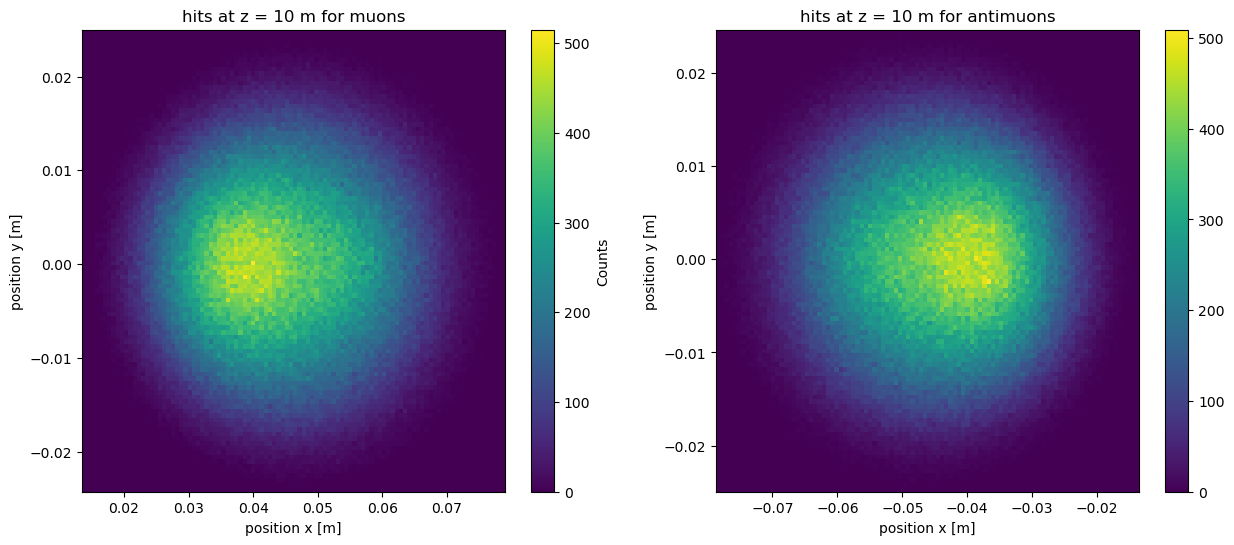

In [57]:
# plot to check the muons location at the exit of the magnetic field
# it can be deleted later
fig, ax = plt.subplots(1, 2, figsize=(15,6))
hist0 = ax[0].hist2d(R_mu_exitB["x"], R_mu_exitB["y"], bins=(100,100), cmap = "viridis")
colorbar = fig.colorbar(hist0[3], ax=ax[0], cmap="viridis")
colorbar.set_label('Counts')
ax[0].set_xlabel("position x [m]")
ax[0].set_ylabel("position y [m]")
ax[0].set_title("hits at z = {} m for muons".format(z_exit))

hist1 = ax[1].hist2d(R_anti_mu_exitB["x"], R_anti_mu_exitB["y"], bins=(100,100), cmap = "viridis")
cbar = fig.colorbar(hist1[3], ax=ax[1], cmap="viridis")
# cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
ax[1].set_xlabel("position x [m]")
ax[1].set_ylabel("position y [m]")
ax[1].set_title("hits at z = {} m for antimuons".format(z_exit))

plt.show()

### Code

In [58]:
# propagation of the muons and antimuons momenta in the magnetic field
P_mu_afterB = propagate_mu_momenta(P_mu, theta_mu)
P_anti_mu_afterB = propagate_antimu_momenta(P_anti_mu, theta_antimu)

#### Quick check

In [59]:
# check for an arbitrary position 
z_exit = 13. # m

R_mu_tmp = propagate_particles(R_mu_exitB, P_mu_afterB, z_exit, muon_mass)
R_anti_mu_tmp = propagate_particles(R_anti_mu_exitB, P_anti_mu_afterB, z_exit, muon_mass)

Text(0, 0.5, 'position y [m]')

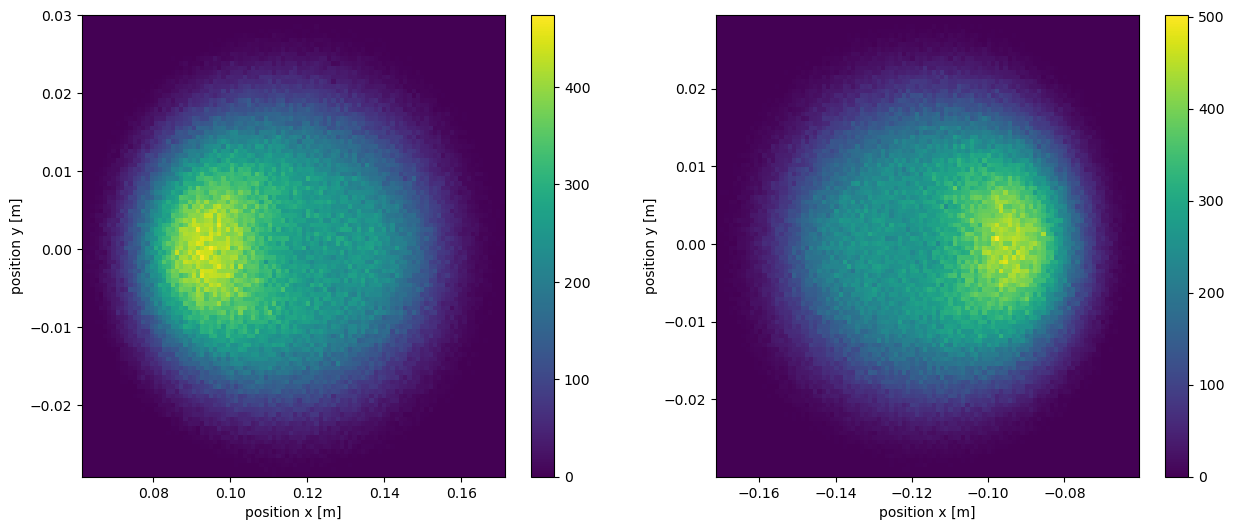

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
hist0 = ax[0].hist2d(R_mu_tmp["x"], R_mu_tmp["y"], bins=(100,100), cmap = "viridis")
cbar = fig.colorbar(hist0[3], ax=ax[0], cmap="viridis")
# cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
ax[0].set_xlabel("position x [m]")
ax[0].set_ylabel("position y [m]")
# ax.set_title("hits at z = {} m".format(data["z"][0]))

hist1 = ax[1].hist2d(R_anti_mu_tmp["x"], R_anti_mu_tmp["y"], bins=(100,100), cmap = "viridis")
cbar = fig.colorbar(hist1[3], ax=ax[1], cmap="viridis")
# cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
ax[1].set_xlabel("position x [m]")
ax[1].set_ylabel("position y [m]")

### Code

In [61]:
z_afterB_muons_detectors = np.array([12., 14., 16.]) # z of the silicon trackers after the magnetic field

r_afterB__muons_positions = {}
afterB_muons_detectors = {}
for z_new in z_afterB_muons_detectors:
    R_mu_tmp = propagate_particles(R_mu_exitB, P_mu_afterB, z_new, muon_mass)
    R_anti_mu_tmp = propagate_particles(R_anti_mu_exitB, P_anti_mu_afterB, z_new, muon_mass)
    data_tmp = {"mu": R_mu_tmp.copy(), "antimu": R_anti_mu_tmp.copy()}
    r_afterB__muons_positions[z_new] = data_tmp

Assuming square pixels of size 200.0x200.0 μm and a tolerance of 1.05 %:

for detector at z=12.0 m we choose:
 - length of 0.104 m along x and 0.0616 m along y
 - center in (0.0977, 0.0005) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 520x308 pixels

for detector at z=12.0 m we choose:
 - length of 0.1044 m along x and 0.0616 m along y
 - center in (-0.0975, -0.0002) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 522x308 pixels

for detector at z=14.0 m we choose:
 - length of 0.1376 m along x and 0.0688 m along y
 - center in (0.1467, 0.0005) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 688x344 pixels

for detector at z=14.0 m we choose:
 - length of 0.1396 m along x and 0.0692 m along y
 - center in (-0.1459, -0.0003) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 698x346 pixels

for detector at z=16.0 m we choose:
 - length of 0.1736 m along x and 0.076 m along y
 

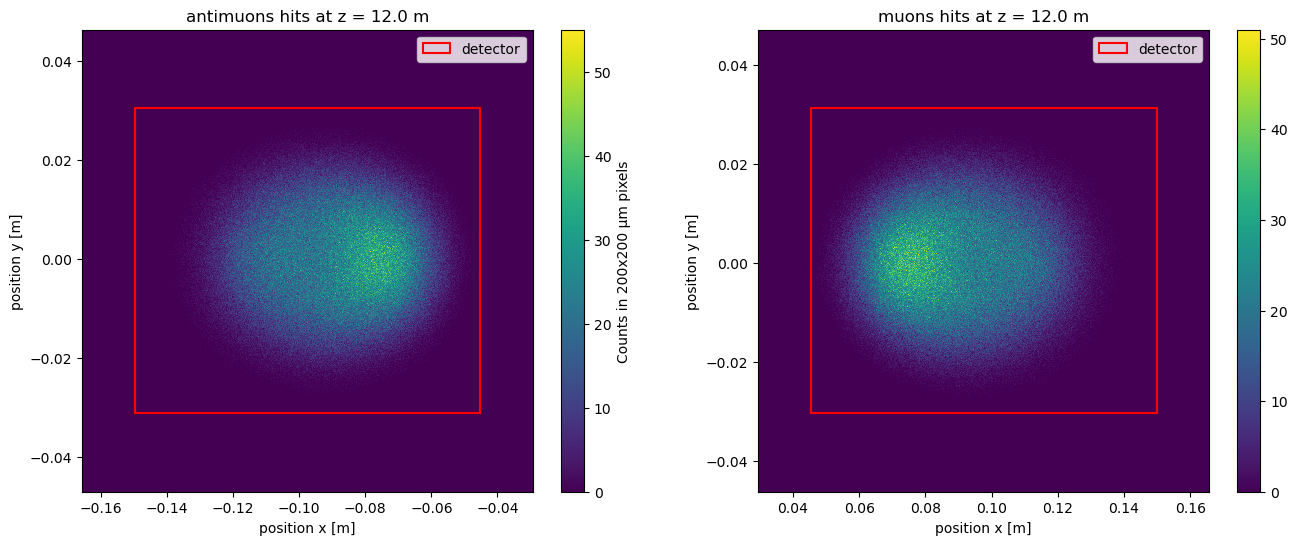

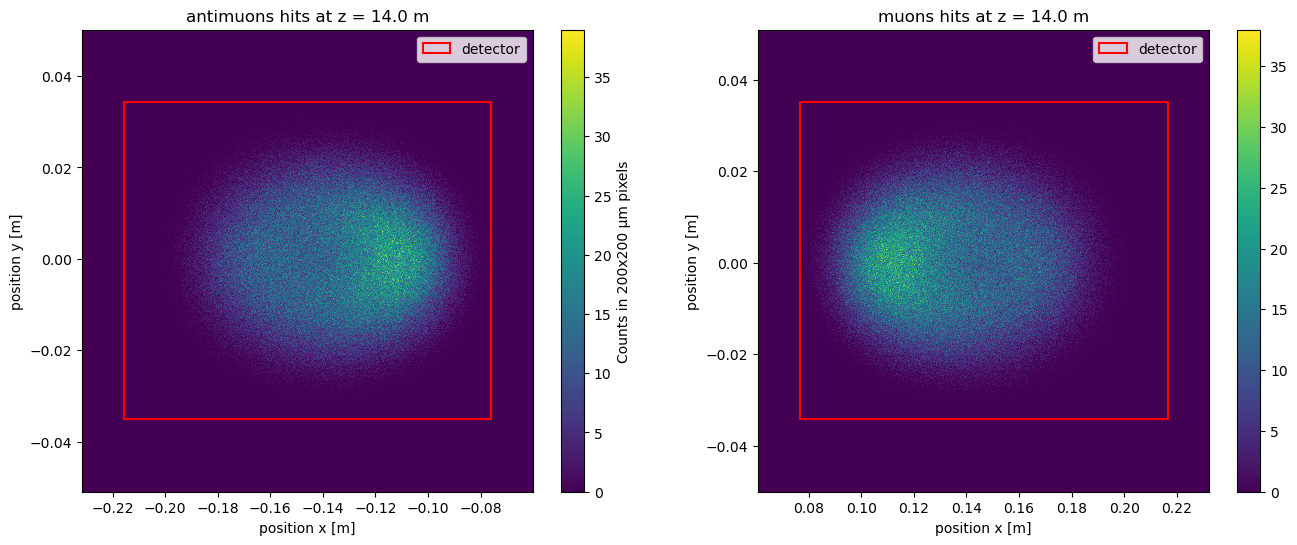

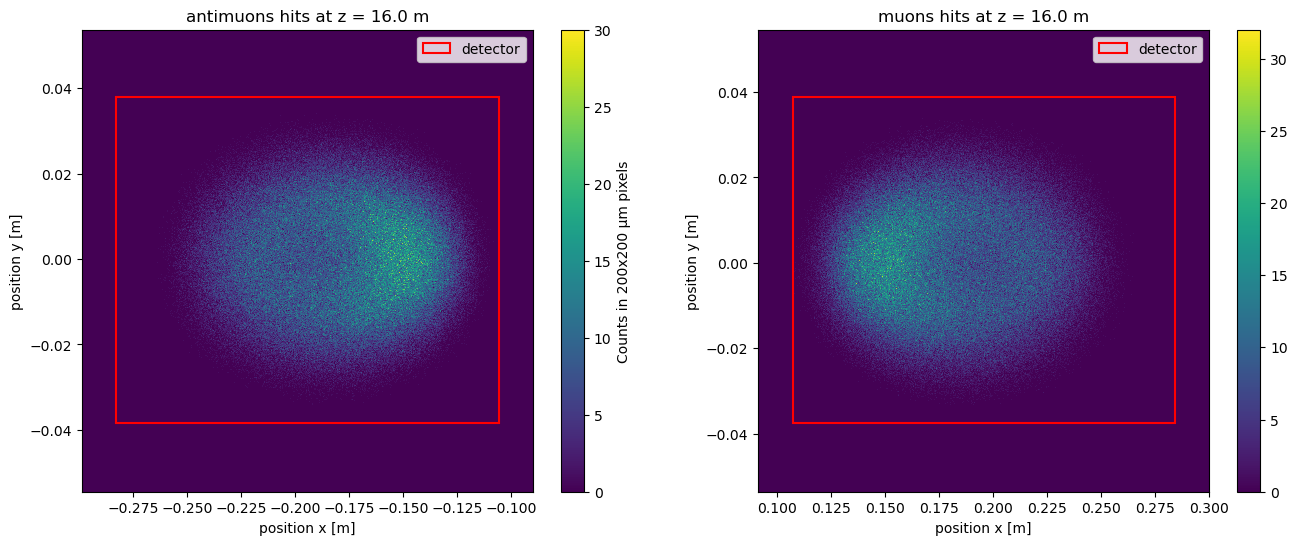

In [62]:
pixel_length = 200e-6 #m
tolerance = 1.05 #%
print("Assuming square pixels of size {}x{} μm and a tolerance of {} %:".format(pixel_length*1e6, pixel_length*1e6, tolerance))

for z_new, data in  r_afterB__muons_positions.items():
    # create hits map
    x_center_mu, y_center_mu, z_center_mu, x_length_mu, y_length_mu, pixel_length_mu = choose_detector_specs(data["mu"], tolerance, pixel_length)
    x_center_antimu, y_center_antimu, z_center_antimu, x_length_antimu, y_length_antimu, pixel_length_antimu = choose_detector_specs(data["antimu"], tolerance, pixel_length)

    x_length = max(x_length_mu, x_length_antimu)
    y_length = max(y_length_mu, y_length_antimu)
    
    edges_mu = get_edges(pixel_length_mu, x_center_mu, y_center_mu, x_length, y_length, 80)
    edges_antimu = get_edges(pixel_length_antimu, x_center_antimu, y_center_antimu, x_length, y_length, 80)

    detector_mu_tmp = Detector(x_center_mu, y_center_mu, z_center_mu, x_length, y_length, pixel_length)
    detector_mu_tmp.load_data(data["mu"])
    detector_antimu_tmp = Detector(x_center_antimu, y_center_antimu, z_center_antimu, x_length, y_length, pixel_length)
    detector_antimu_tmp.load_data(data["antimu"])
    
    detector_tmp = {
                    "mu": detector_mu_tmp,
                    "antimu": detector_antimu_tmp
                   }
    afterB_muons_detectors[z_new]=detector_tmp

    #plot hits maps
    df_positions_mu = detector_tmp["mu"].get_positions()
    df_positions_antimu = detector_tmp["antimu"].get_positions()
    fig, ax = plt.subplots(1, 2, figsize = (16, 6) )
    hist_muons = ax[1].hist2d(df_positions_mu["x"],df_positions_mu["y"], bins=edges_mu, cmap = "viridis")
    hist_antimuons = ax[0].hist2d(df_positions_antimu["x"], df_positions_antimu["y"], bins=edges_antimu, cmap = "viridis")

    colorbar = fig.colorbar(hist_muons[3], ax=ax[1], cmap="viridis")
    colorbar = fig.colorbar(hist_antimuons[3], ax=ax[0], cmap="viridis")
    pixel_length_label = round(pixel_length*1e6)
    colorbar.set_label('Counts in {}x{} μm pixels'.format(pixel_length_label, pixel_length_label))
    labels = ["antimuons", "muons"]
    for a, lab in zip(ax, labels):
        a.set_xlabel("position x [m]")
        a.set_ylabel("position y [m]")
        a.set_title("{} hits at z = {} m".format(lab, z_new))
    place_detector_on_hitsmap(ax[1], x_center_mu, y_center_mu, x_length, y_length)
    place_detector_on_hitsmap(ax[0], x_center_antimu, y_center_antimu, x_length, y_length)